In [1]:
!pip install yfinance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import datetime
from matplotlib import pyplot as plt

import yfinance as yf
import seaborn
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

%matplotlib inline
pd.options.mode.chained_assignment = None
plt.rcParams["figure.figsize"] = (20,10)

     |████████████████████████████████| 6.3MB 6.6MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.61-py2.py3-none-any.whl size=23818 sha256=7e5c0d8f7bb7c9b35931171fcea71e16861c46aae98afe29f9940233a22d288d
  Stored in directory: /root/.cache/pip/wheels/9c/b3/31/b5f2bcf2e3fd3f42e5ca1a3d20ada27eae8cbda7de75a5a2a0
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def dropDates(a, b):
  ## Remove dates in a but not in b
  for i in a.index:
    if i not in b.index:
      a.drop(i,axis=0,inplace=True)
  ## Remove dates in b but not in a
  for i in b.index:
    if i not in a.index:
      b.drop(i,axis=0,inplace=True)

In [3]:
# Interpolation

def modify_stock(pr):
  pr.reset_index(level=0, inplace=True)
  def imput_date(df:pd.DataFrame,col:'Date'):
    start = datetime.datetime.strptime(df.loc[0,col],'%Y-%m-%d')
    end = datetime.datetime.strptime(df.loc[df.shape[0] - 1,col],'%Y-%m-%d')
    list_date = pd.date_range(start,end).strftime('%Y-%m-%d').tolist()
    pd_date = pd.DataFrame(df,list_date)
    pd_date[col] = pd_date.index.astype(object)
    pd_date = pd_date.reset_index(drop=True)
    df_date = pd.merge(pd_date[col],df,on=col,how='left')
    return df_date

  # Curve function
  def curve_function(df):
      for i in df.columns:
          while df[i].isna().sum() > 0:
              for j in range(df.shape[0]):
                  if pd.isnull(df.loc[j,i]):
                      seq_k = [j]
                      k = j
                      while pd.isnull(df.loc[k,i]):
                          k = k + 1
                          seq_k.append(k)
                      if len(seq_k) % 2 == 0:
                          df.loc[seq_k[int((len(seq_k) - 1)/2)],i] = (df.loc[j - 1,i] + df.loc[seq_k[len(seq_k) - 1],i])/2
                      else:
                          df.loc[seq_k[int((len(seq_k) - 1)/2)],i] = (df.loc[j - 1,i] + df.loc[seq_k[len(seq_k) - 1],i])/2
                  else:
                      df.loc[j,i] = df.loc[j,i]
      return(df)

  pr['Date'] = pr['Date'].dt.strftime('%Y-%m-%d')
  pr = pr.pipe(imput_date,col='Date')
  # Create dummy variable for deterimining free day or not
  free = []
  for i in range(pr.shape[0]):
      if pd.isna(pr.iloc[i]['Volume']):
          free.append(0)
      else:
          free.append(1)
  pr_n = pr.pipe(curve_function)
  return(pr_n)

In [4]:
def mtom(ticker1, ticker2):
  a = yf.Ticker(ticker1).history(start="2018-01-01",  end="2020-11-30")
  b = yf.Ticker(ticker2).history(start="2018-01-01",  end="2020-11-30")
  
  ##### Option 1: Dropdates
  dropDates(a, b)
  #####
  
  ##### Option 2: Interpolation
  # a = modify_stock(a)  # modified
  # b = modify_stock(b)  # modified
  #####

  ##### Set the number of rows/columns you want to see for each dataframe
  pd.set_option('display.max_columns', None)
  # pd.set_option('display.max_rows', None)

  len1 = len(a.index)
  len2 = len(b.index)

  ##### HYPERPARAMETERS
  window_size = 3 ### For moving average
  nstd = 2.5 ### To define upper and lower bounds beyond which trading starts
  n = 1 ### Cointegration coefficient
  #####

  idx = 126 + 3 * window_size - 3 ### We are considering surplus data (more than 126 days) which will help us calculate moving averages later. 
  dates = []
  priceA = []
  priceB = []

  while idx > 0:
    priceA.append(a.Close[len1 - idx])
    priceB.append(b.Close[len2 - idx])
    dates.append(a.index[len1-idx])
    idx -= 1
  
  df = pd.DataFrame({'Dates':dates, 'Stock1': priceA, 'Stock2': priceB})
  df['Spread'] = np.log(df['Stock1']) - n*np.log(df['Stock2'])
  df['Spread_Mean'] = df['Spread'].rolling(window_size).mean()
  df['Spread_SD'] = df['Spread'].rolling(window_size).std()
  df['Z_Score'] = (df['Spread'] - df['Spread_Mean'])/df['Spread_SD']
  df['ZMA'] = df['Z_Score'].rolling(window_size).mean()
  df['Zscore_SD'] = df['ZMA'].rolling(window_size).std()
  df['Upper'] = df['ZMA'] + nstd * df['Zscore_SD']
  df['Lower'] = df['ZMA'] - nstd * df['Zscore_SD']
  df['Trading'] = ((df['Z_Score'] >= df['Upper']) | (df['Z_Score'] <= df['Lower']))
  df = df.dropna()
  df = df.reset_index(drop=True)

  mtm1 = pd.DataFrame({'Dates':df['Dates'], 'Close': df['Stock1']})
  mtm1['Signal'] = ""
  mtm1['Change in value'] = 0.0
  mtm1['Gain/Loss'] = ""
  mtm1['Cumulative Gain/Loss'] = ""
  mtm1['Ticker symbol'] = ticker1

  mtm2 = pd.DataFrame({'Dates':df['Dates'], 'Close': df['Stock2']})
  mtm2['Signal'] = ""
  mtm2['Change in value'] = 0.0
  mtm2['Gain/Loss'] = ""
  mtm2['Cumulative Gain/Loss'] = ""
  mtm2['Ticker symbol'] = ticker2

  plt.plot(df['Z_Score'])
  plt.plot(df['ZMA'])
  plt.plot(df['Upper'])
  plt.plot(df['Lower'])
  plt.show()

  plt.plot(df['Stock1'])
  plt.plot(df['Stock2'])
  plt.show()

  last_trading = False
  stock1_long = False
  
  enter_price_1 = 0
  cumulative_1 = 0

  enter_price_2 = 0
  cumulative_2 = 0

  enter = []
  for idx, tading_today in enumerate(df['Trading']):

    if idx != 0:
      mtm1['Change in value'][idx] = mtm1['Close'][idx] - mtm1['Close'][idx - 1]
      mtm2['Change in value'][idx] = mtm2['Close'][idx] - mtm2['Close'][idx - 1]

    ##### Regular trading day
    if last_trading and tading_today:
      if stock1_long:
        mtm1['Gain/Loss'][idx] = df.Stock1[idx] - enter_price_1
        mtm2['Gain/Loss'][idx] = enter_price_2 - df.Stock2[idx]
      else:
        mtm1['Gain/Loss'][idx] = enter_price_1 - df.Stock1[idx]
        mtm2['Gain/Loss'][idx] = df.Stock2[idx] - enter_price_2

      mtm1['Cumulative Gain/Loss'][idx] = cumulative_1 + mtm1['Gain/Loss'][idx]

      mtm2['Cumulative Gain/Loss'][idx] = cumulative_2 + mtm2['Gain/Loss'][idx]

    ##### Entering Trade
    if not last_trading and tading_today:

      enter_price_1 = df.Stock1[idx]

      enter_price_2 = df.Stock2[idx]

      if (df.Z_Score[idx] >= df.Upper[idx]):
        if df.Stock1[idx] - df.Stock2[idx] < 0:
          stock1_long = True
      elif (df.Z_Score[idx] <= df.Lower[idx]):
        if df.Stock1[idx] - df.Stock2[idx] > 0:
          stock1_long = True
      if stock1_long:
        mtm1.Signal[idx] = 'BUY'
        mtm2.Signal[idx] = 'SELL'
      else:
        mtm1.Signal[idx] = 'SELL'
        mtm2.Signal[idx] = 'BUY'
      last_trading = True

    ##### Closing Trade
    elif last_trading and not tading_today:
      
      if stock1_long:
        mtm1['Gain/Loss'][idx] = df.Stock1[idx] - enter_price_1
        mtm2['Gain/Loss'][idx] = enter_price_2 - df.Stock2[idx]
        mtm1.Signal[idx] = 'SELL'
        mtm2.Signal[idx] = 'BUY'
      else:
        mtm1['Gain/Loss'][idx] = enter_price_1 - df.Stock1[idx]
        mtm2['Gain/Loss'][idx] = df.Stock2[idx] - enter_price_2
        mtm1.Signal[idx] = 'BUY'
        mtm2.Signal[idx] = 'SELL'

      cumulative_1 += mtm1['Gain/Loss'][idx]
      mtm1['Cumulative Gain/Loss'][idx] = cumulative_1
        
      cumulative_2 += mtm2['Gain/Loss'][idx]
      mtm2['Cumulative Gain/Loss'][idx] = cumulative_2
        
      stock1_long = False
      last_trading = False

  ##### If last trade is not squared off before the end of the entire trading period (126 days)
  if last_trading:
    if stock1_long:
      mtm1['Gain/Loss'][idx] = df.Stock1[idx] - enter_price_1
      mtm2['Gain/Loss'][idx] = enter_price_2 - df.Stock2[idx]
      mtm1.Signal[idx] = 'SELL'
      mtm2.Signal[idx] = 'BUY'
    else:
      mtm1['Gain/Loss'][idx] = enter_price_1 - df.Stock1[idx]
      mtm2['Gain/Loss'][idx] = df.Stock2[idx] - enter_price_2
      mtm1.Signal[idx] = 'BUY'
      mtm2.Signal[idx] = 'SELL'
#####

  return (df, mtm1, mtm2)

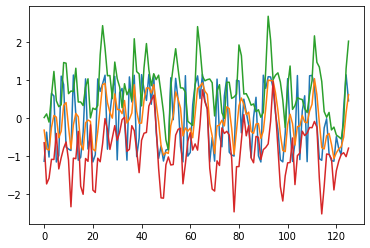

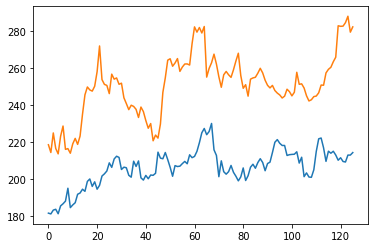

In [5]:
# msft = yf.Ticker('MSFT').history(start="2018-01-01",  end="2020-11-30")
# # For MSFT, pair found by interpolation is MAHEPC.NS
# mahepc = yf.Ticker('MAHEPC.NS').history(start="2018-01-01",  end="2020-11-30") # DD: 73.39002990722656 I: -25.715126037597656
# # For MSFT, pair found by drop-dates is ASALCBR.NS
# asalcbr = yf.Ticker('ASALCBR.NS').history(start="2018-01-01",  end="2020-11-30") # DD:51.09440612792969 I:19.646106719970703

# goog = yf.Ticker('GOOG').history(start="2018-01-01",  end="2020-11-30")
# # For GOOG, pair found by interpolation is KPITTECH.NS
# kpittech = yf.Ticker('KPITTECH.NS').history(start="2018-01-01",  end="2020-11-30") # DD:-53.43960189819336 I:-501.8075695037842
# # For GOOG, pair found by drop-dates are BCG.NS and SUVENPHAR.NS
# bcg = yf.Ticker('BCG.NS').history(start="2018-01-01",  end="2020-11-30") # DD:190.51996898651123 I: 177.94522216916084
# suvenphar = yf.Ticker('SUVENPHAR.NS').history(start="2018-01-01",  end="2020-11-30") # DD:114.74046325683594 I: -12.317420959472656

# # reliance = yf.Ticker('RELIANCE.NS').history(start="2018-01-01",  end="2020-11-30")
# # sumichem = yf.Ticker('SUMICHEM.NS').history(start="2018-01-01",  end="2020-11-30")

(all_data, df1, df2) = mtom('MSFT', 'ASALCBR.NS')

In [6]:
# Uncomment to display all rows in dataframe:
pd.set_option('display.max_rows', None)

# Uncomment to display all columns in a single line
pd.set_option('expand_frame_repr', False)

In [7]:
print (all_data)

         Dates      Stock1      Stock2    Spread  Spread_Mean  Spread_SD   Z_Score       ZMA  Zscore_SD     Upper     Lower  Trading
0   2020-05-29  181.492691  218.474854 -0.185456    -0.124487   0.053730 -1.134712 -0.314225   0.132473  0.016958 -0.645407     True
1   2020-06-01  181.076721  214.289703 -0.168408    -0.152607   0.042985 -0.367592 -0.809779   0.369094  0.112957 -1.732514    False
2   2020-06-02  183.136765  224.852219 -0.205210    -0.186358   0.018418 -1.023597 -0.841967   0.295838 -0.102371 -1.581563    False
3   2020-06-03  183.582458  216.481918 -0.164843    -0.179487   0.022348  0.655271 -0.245306   0.335576  0.593635 -1.084247     True
4   2020-06-04  181.165863  213.542358 -0.164422    -0.178158   0.023428  0.586309  0.072661   0.464337  1.233503 -1.088181    False
5   2020-06-05  185.404800  223.058594 -0.184893    -0.171386   0.011699 -1.154514  0.029022   0.172367  0.459941 -0.401897     True
6   2020-06-08  186.553680  228.588959 -0.203206    -0.184174   0.019

In [8]:
print (df1)

         Dates       Close Signal  Change in value  Gain/Loss Cumulative Gain/Loss Ticker symbol
0   2020-05-29  181.492691   SELL         0.000000                                          MSFT
1   2020-06-01  181.076721    BUY        -0.415970    0.41597              0.41597          MSFT
2   2020-06-02  183.136765                2.060043                                          MSFT
3   2020-06-03  183.582458    BUY         0.445694                                          MSFT
4   2020-06-04  181.165863   SELL        -2.416595    -2.4166             -2.00063          MSFT
5   2020-06-05  185.404800   SELL         4.238937                                          MSFT
6   2020-06-08  186.553680    BUY         1.148880   -1.14888             -3.14951          MSFT
7   2020-06-09  187.979889    BUY         1.426208                                          MSFT
8   2020-06-10  194.952362   SELL         6.972473    6.97247              3.82297          MSFT
9   2020-06-11  184.483734   S

In [9]:
print(df2)

         Dates       Close Signal  Change in value  Gain/Loss Cumulative Gain/Loss Ticker symbol
0   2020-05-29  218.474854    BUY         0.000000                                    ASALCBR.NS
1   2020-06-01  214.289703   SELL        -4.185150   -4.18515             -4.18515    ASALCBR.NS
2   2020-06-02  224.852219               10.562515                                    ASALCBR.NS
3   2020-06-03  216.481918   SELL        -8.370300                                    ASALCBR.NS
4   2020-06-04  213.542358    BUY        -2.939560    2.93956             -1.24559    ASALCBR.NS
5   2020-06-05  223.058594    BUY         9.516235                                    ASALCBR.NS
6   2020-06-08  228.588959   SELL         5.530365    5.53036              4.28477    ASALCBR.NS
7   2020-06-09  215.983688   SELL       -12.605270                                    ASALCBR.NS
8   2020-06-10  216.382278    BUY         0.398590   -0.39859              3.88618    ASALCBR.NS
9   2020-06-11  213.891113    